# Ajuste de datos experimentales a osciladores

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

## Lectura de datos exportados de tracker

In [3]:
# Definimos una función para leer los datos de un txt de tiempo, posición, velocidad y aceleración
# quitando la ultima columna, normalizando el tiempo entre 0 y 1, convirtiendo de m a cm,
# iniciando la posición en 0
def leer_datos(nombre_pelota):
    ruta = "../Tracking/tablas_datos/Datos_" + nombre_pelota + ".txt"
    datos = pd.read_csv(ruta, sep = "\t", skiprows=1, decimal=",")
    datos.drop(datos.columns[len(datos.columns)-1], axis=1, inplace=True)
    datos["t"] = datos["t"] - datos["t"].min()
    # datos["t"] = (datos["t"] - datos["t"].min()) / (datos["t"].max() - datos["t"].min())
    for columna in datos.columns[1:]:
        datos[columna] = datos[columna] * 100
    datos["x"] = datos["x"] - datos["x"].min()
    return datos

In [40]:
# Leemos los datos de goma, pingpong, plastGrand y pingpong_2D
datos_goma = leer_datos("goma")
datos_pingpong = leer_datos("pingpong")
datos_plastGrand = leer_datos("plastGrand")
datos_pingpong_2D = leer_datos("pingpong_2D")

# Eliminar ultimos datos de goma
datos_goma.drop(datos_goma.index[-2:], inplace = True)

# Corrección para la de pingpong
for columna in datos_pingpong.columns[1:]:
    datos_pingpong[columna] = datos_pingpong[columna] * 1e29

# Centrar las oscilaciones
datos_pingpong["x"] = datos_pingpong["x"] - datos_pingpong["x"].mean()

# Centrar las oscilaciones amortiguadas
datos_goma["x"] = datos_goma["x"] - datos_goma["x"].iloc[-1]
datos_plastGrand["x"] = datos_plastGrand["x"] - datos_plastGrand["x"].iloc[-1]


In [32]:
# datos_goma.head(4)
datos_pingpong.head(4)
# datos_plastGrand.head(4)
# datos_pingpong_2D.head(4)

,t,x,vx,ax
0,0.000,0.807264,NaN,NaN
1,0.033,0.387264,-13.330,NaN
2,0.067,-0.082736,-12.150,94.42
3,0.100,-0.422736,-6.886,243.20


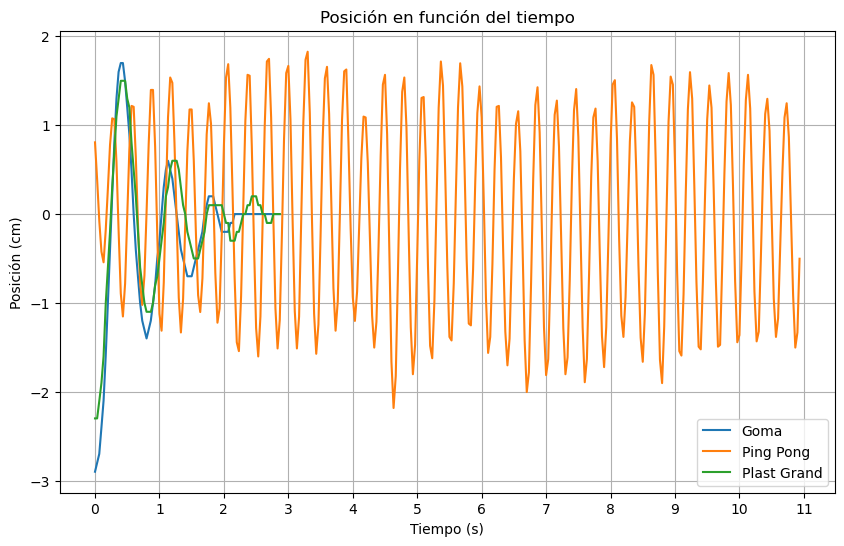

In [46]:
# Graficamos la posición en función del tiempo de las 3 pelotas 1D
plt.figure(figsize=(10,6))
plt.plot(datos_goma["t"], datos_goma["x"], label="Goma")
plt.plot(datos_pingpong["t"], datos_pingpong["x"], label="Ping Pong")
plt.plot(datos_plastGrand["t"], datos_plastGrand["x"], label="Plast Grand")
plt.xticks(np.arange(0, datos_pingpong["t"].max()+1, 1))
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (cm)")
plt.title("Posición en función del tiempo")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Graficamos la velocidad en función del tiempo de las 3 pelotas 1D
plt.figure(figsize=(10,6))
plt.plot(datos_goma["t"], datos_goma["vx"], label="Goma")
plt.plot(datos_pingpong["t"], datos_pingpong["vx"], label="Ping Pong")
plt.plot(datos_plastGrand["t"], datos_plastGrand["vx"], label="Plast Grand")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (cm/s)")
plt.title("Velocidad en función del tiempo")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Graficamos la aceleración en función del tiempo de las 3 pelotas 1D
plt.figure(figsize=(10,6))
plt.plot(datos_goma["t"], datos_goma["ax"], label="Goma")
plt.plot(datos_pingpong["t"], datos_pingpong["ax"], label="Ping Pong")
plt.plot(datos_plastGrand["t"], datos_plastGrand["ax"], label="Plast Grand")
plt.xlabel("Tiempo (s)")
plt.ylabel("Aceleración (cm/s²)")
plt.title("Aceleración en función del tiempo")
plt.legend()
plt.grid()
plt.show()

## Selección de modelos

In [63]:
# Definimos las funciones de ajuste
def oscilacion(t, A, w, phi):
    return A*1e-2 * np.cos(w * t + phi)

def oscilacion_amortiguada(t, A, w, phi, gamma):
    return A * np.exp(-gamma * t) * np.cos(w * t + phi)

# Ajustamos los datos de la pelota de goma usando curve_fit
popt_goma, pcov_goma = curve_fit(oscilacion_amortiguada, datos_goma["t"], datos_goma["x"], p0=[3, 2*np.pi*1.25, 0, 0.1])

# Ajustamos los datos de la pelota de pingpong usando curve_fit
popt_pingpong, pcov_pingpong = curve_fit(oscilacion, datos_pingpong["t"], datos_pingpong["x"], p0=[1, 2*np.pi*3.5, 0])

# Ajustamos los datos de la pelota de plastGrand usando curve_fit
popt_plastGrand, pcov_plastGrand = curve_fit(oscilacion_amortiguada, datos_plastGrand["t"], datos_plastGrand["x"], p0=[2.5, 2*np.pi*1.25, 0, 0.1])

# Imprimimos los parámetros de ajuste de las 3 pelotas
print("Pelota de goma:", end="\n")
print("A =", round(popt_goma[0], 3), "+-", round(np.sqrt(pcov_goma[0,0]), 3), "w =", round(popt_goma[1], 3), "+-", round(np.sqrt(pcov_goma[1,1]), 3), "phi =", round(popt_goma[2], 3), "+-", round(np.sqrt(pcov_goma[2,2]), 3), "gamma =", round(popt_goma[3], 3), "+-", round(np.sqrt(pcov_goma[3,3]), 3), end="\n\n")
print("Pelota de pingpong:", end="\n")
print("A =", round(popt_pingpong[0]*1e-2, 3), "+-", round(np.sqrt(pcov_pingpong[0,0])*1e-2, 3), "w =", round(popt_pingpong[1], 3), "+-", round(np.sqrt(pcov_pingpong[1,1]), 3), "phi =", round(popt_pingpong[2], 3), "+-", round(np.sqrt(pcov_pingpong[2,2]), 3), end="\n\n")
print("Pelota de plastGrand:", end="\n")
print("A =", round(popt_plastGrand[0], 3), "+-", round(np.sqrt(pcov_plastGrand[0,0]), 3), "w =", round(popt_plastGrand[1], 3), "+-", round(np.sqrt(pcov_plastGrand[1,1]), 3), "phi =", round(popt_plastGrand[2], 3), "+-", round(np.sqrt(pcov_plastGrand[2,2]), 3), "gamma =", round(popt_plastGrand[3], 3), "+-", round(np.sqrt(pcov_plastGrand[3,3]), 3), end="\n\n")


Pelota de goma:
A = -3.092 +- 0.107 w = 8.692 +- 0.083 phi = -0.592 +- 0.047 gamma = 1.315 +- 0.071

Pelota de pingpong:
A = 1.471 +- 0.025 w = 21.065 +- 0.005 phi = 0.1 +- 0.033

Pelota de plastGrand:
A = -2.495 +- 0.087 w = 8.024 +- 0.077 phi = -0.416 +- 0.047 gamma = 1.203 +- 0.066



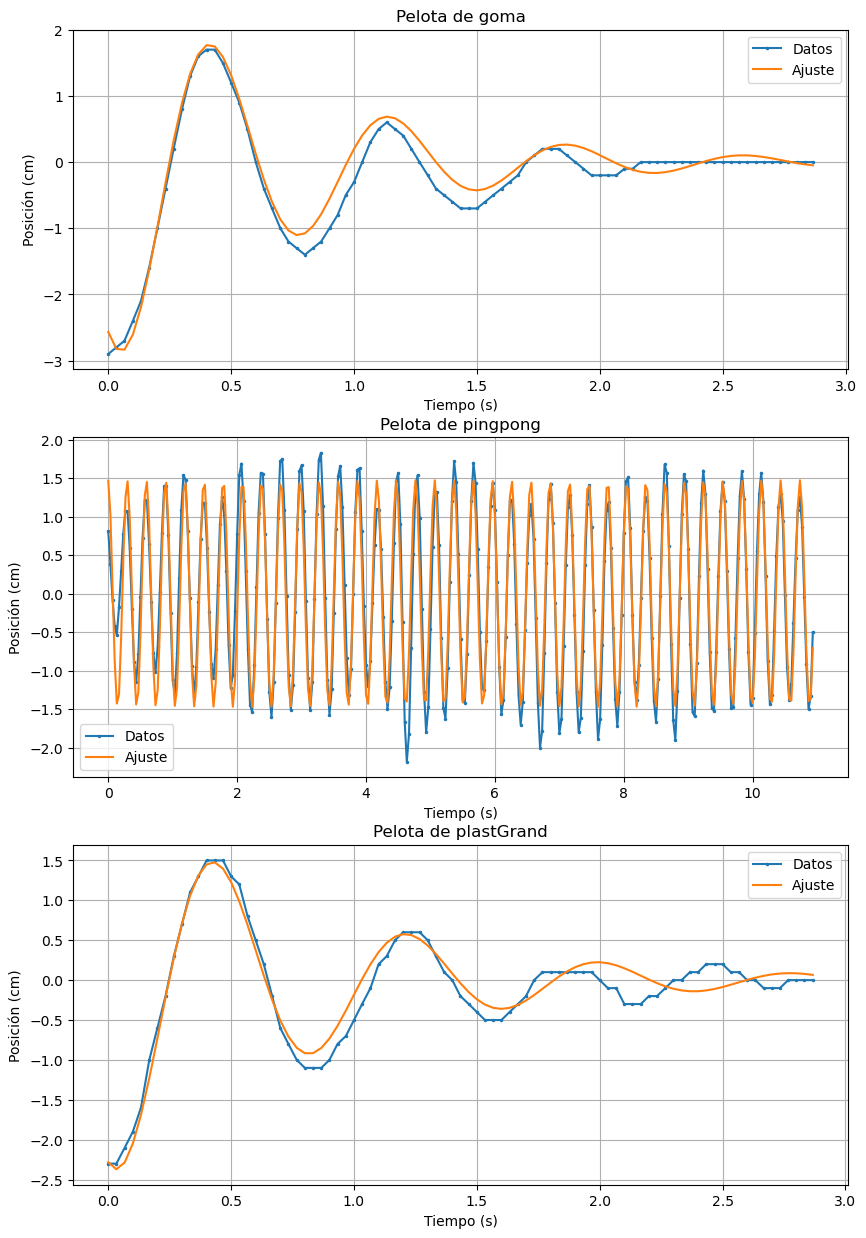

In [64]:
# Graficamos los datos y los ajustes de las 3 pelotas en 3 subplots diferentes
fig, axs = plt.subplots(3, 1, figsize=(10,15))
axs[0].plot(datos_goma["t"], datos_goma["x"], ".-", label="Datos", markersize=3)
axs[0].plot(datos_goma["t"], oscilacion_amortiguada(datos_goma["t"], *popt_goma), label="Ajuste")
axs[0].set_title("Pelota de goma")
axs[0].set_xlabel("Tiempo (s)")
axs[0].set_ylabel("Posición (cm)")
axs[0].legend()
axs[0].grid()

axs[1].plot(datos_pingpong["t"], datos_pingpong["x"], ".-", label="Datos", markersize=3)
axs[1].plot(datos_pingpong["t"], oscilacion(datos_pingpong["t"], *popt_pingpong), label="Ajuste")
axs[1].set_title("Pelota de pingpong")
axs[1].set_xlabel("Tiempo (s)")
axs[1].set_ylabel("Posición (cm)")
axs[1].legend()
axs[1].grid()

axs[2].plot(datos_plastGrand["t"], datos_plastGrand["x"], ".-", label="Datos", markersize=3)
axs[2].plot(datos_plastGrand["t"], oscilacion_amortiguada(datos_plastGrand["t"], *popt_plastGrand), label="Ajuste")
axs[2].set_title("Pelota de plastGrand")
axs[2].set_xlabel("Tiempo (s)")
axs[2].set_ylabel("Posición (cm)")
axs[2].legend()
axs[2].grid()

plt.show()

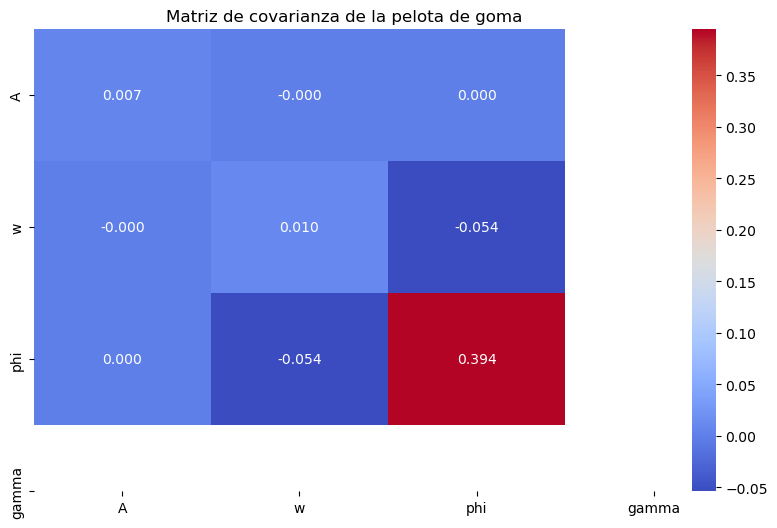

In [56]:
# matriz de covarianza de pingpong marplotlib con labels
plt.figure(figsize=(10,6))
sns.heatmap(pcov_pingpong, annot=True, fmt=".3f", cmap="coolwarm")
plt.xticks([0.5, 1.5, 2.5, 3.5], ["A", "w", "phi", "gamma"])
plt.yticks([0.5, 1.5, 2.5, 3.5], ["A", "w", "phi", "gamma"])
plt.title("Matriz de covarianza de la pelota de goma")
plt.show()